## $\color{teal}{\text{Install syft for virtual workers}}$

In [ ]:
pip install syft==0.2.9 --user

     |████████████████████████████████| 433 kB 5.2 MB/s 
     |████████████████████████████████| 4.0 MB 36.7 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 753.4 MB 6.8 kB/s 
     |████████████████████████████████| 200 kB 25.0 MB/s 
     |████████████████████████████████| 1.8 MB 36.7 MB/s 
     |████████████████████████████████| 9.0 MB 18.6 MB/s 
     |████████████████████████████████| 66 kB 3.6 MB/s 
     |████████████████████████████████| 126 kB 50.5 MB/s 
     |████████████████████████████████| 484 kB 46.7 MB/s 
     |████████████████████████████████| 449 kB 42.6 MB/s 
     |████████████████████████████████| 57 kB 5.3 MB/s 
     |████████████████████████████████| 2.0 MB 32.8 MB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 79 kB 7.7 MB/s 
     |████████████████████████████████| 73 kB 2.1 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████

## $\color{teal}{\text{Load the necessary libraries}}$

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.io import loadmat

import torch as th
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset
from torch import nn
import torch.nn.functional as F
from torch import optim
import syft as sy
import helper

## $\color{teal}{\text{ Hook PyTorch ie add extra functionalities to support Federated Learning}}$

In [ ]:
hook = sy.TorchHook(th)

## $\color{teal}{\text{ Create virtual workers}}$

In [ ]:
def create_workers():
  workers = []
  WORKER1 = sy.VirtualWorker(hook, id = "WORKER1")
  workers.append(WORKER1)
  WORKER2 = sy.VirtualWorker(hook, id = "WORKER2")
  workers.append(WORKER2)
  WORKER3 = sy.VirtualWorker(hook, id = "WORKER3")
  workers.append(WORKER3)
  WORKER4 = sy.VirtualWorker(hook, id = "WORKER4")
  workers.append(WORKER4)
  
  return workers

In [ ]:
def clear_workers(workers):
  for worker in workers:
    worker.clear_objects()

## $\color{teal}{\text{ Define the architechure}}$

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## $\color{teal}{\text{Load the test and train dataset}}$

In [ ]:
batch_size_train = 64
batch_size_test = 1000

In [ ]:
fmnist_trainset = th.utils.data.DataLoader(
 datasets.MNIST('/files/', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
fmnist_testset = th.utils.data.DataLoader(
 datasets.MNIST('/files/', train=False, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

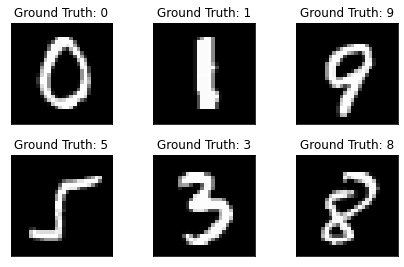

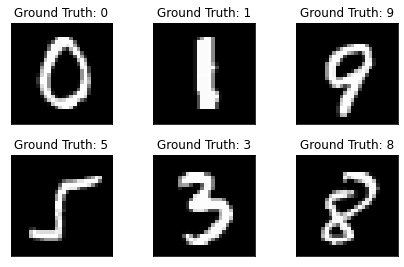

In [ ]:
examples = enumerate(fmnist_testset)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## $\color{teal}{\text{Split the data to federated}}$

In [ ]:
def refined_df(w, train_, test_):
  fed_train_loader = sy.FederatedDataLoader(train_.federate(w), batch_size=32)
  fed_test_loader = th.utils.data.DataLoader(test_, batch_size=64)
  return fed_train_loader, fed_test_loader

## $\color{teal}{\text{Federated workers and model}}$

In [ ]:
def fed_ml(workers, loader, lr = 0.12, epoch = 5):
  virtual_models, virtual_optimizers = create_models(workers, lr)
  criterion = nn.NLLLoss()
  for n in range(epoch):
    i = 0
    j = 0
    count = 0
    dbLoc = None
    cum_loss = 0
    for count_idx, (imgs, labels) in enumerate(loader):      
      if i == 0:
        i = 2
        dbLoc = imgs.location        
      if dbLoc is not imgs.location:#calculate loss
        print("The total loss for {0} for epoch {2} is {1}".format(workers[j].id, cum_loss / count, n+1))
        dbLoc = imgs.location
        j += 1             
        cum_loss = 0 #new- worker
        count = 0
      virtual_optimizers[j].zero_grad()
      output = virtual_models[j].forward(imgs)
      loss = criterion(output, labels)
      loss.backward()
      virtual_optimizers[j].step()
      cum_loss +=  loss.get().item()
      count += 1
    print("The total loss for {0} is {1}".format(workers[j].id, cum_loss / count))
  return virtual_models

## $\color{teal}{\text{Create models and distributed}}$

In [ ]:
def create_models(workers, lr):
  remoteModels = list()
  remoteOptimizers = list()
  for worker in workers:
    model = Net()
    model = model.send(worker)  #send data from one socket to another socket
    remoteOptimizers.append(optim.SGD(model.parameters(), lr))
    remoteModels.append(model)
  return remoteModels, remoteOptimizers

In [ ]:
def central_model(model):
  return model.get()

In [ ]:
def central_to_local(models, workers):
  for model in models:
    model.fc1.weight.data = model.fc1.weight.data.fix_prec().share(*workers)  #convert PyTorch Float tensors into Fixed Precision Tensors
    model.fc1.bias.data = model.fc1.bias.data.fix_prec().share(*workers)
    model.fc2.weight.data = model.fc2.weight.data.fix_prec().share(*workers)
    model.fc2.bias.data = model.fc2.bias.data.fix_prec().share(*workers)
    model.conv1.weight.data = model.conv1.weight.data.fix_prec().share(*workers)
    model.conv1.bias.data = model.conv1.bias.data.fix_prec().share(*workers)
    model.conv2.weight.data = model.conv2.weight.data.fix_prec().share(*workers)
    model.conv2.bias.data = model.conv2.bias.data.fix_prec().share(*workers)
  return models

In [ ]:
def accumulate(models):
  fc1_weight = list()
  fc1_bias = list()
  fc2_weight = list()
  fc2_bias = list()
  conv1_weight = list()
  conv1_bias = list()
  conv2_weight = list()
  conv2_bias = list()
  for model in models:
    fc1_weight.append(model.fc1.weight.data.clone().get())
    fc1_bias.append(model.fc1.bias.data.clone().get())
    fc2_weight.append(model.fc2.weight.data.clone().get())
    fc2_bias.append(model.fc2.bias.data.clone().get())
    conv1_weight.append(model.conv1.weight.data.clone().get())
    conv1_bias.append(model.conv1.bias.data.clone().get())
    conv2_weight.append(model.conv2.weight.data.clone().get())
    conv2_bias.append(model.conv2.bias.data.clone().get())
  param = {}
  param["fc1.weight"] = (sum(fc1_weight) / len(fc1_weight)).get().float_prec()
  param["fc1.bias"] = (sum(fc1_bias) / len(fc1_bias)).get().float_prec()
  param["fc2.weight"] = (sum(fc2_weight) / len(fc2_weight)).get().float_prec()
  param["fc2.bias"] = (sum(fc2_bias) / len(fc2_bias)).get().float_prec()
  param["conv1.weight"] = (sum(conv1_weight) / len(conv1_weight)).get().float_prec()
  param["conv1.bias"] = (sum(conv1_bias) / len(conv1_bias)).get().float_prec()
  param["conv2.weight"] = (sum(conv2_weight) / len(conv2_weight)).get().float_prec()
  param["conv2.bias"] = (sum(conv2_bias) / len(conv2_bias)).get().float_prec()
  return param

In [ ]:
def update(param):
  model = Net()
  model.fc1.weight.data = param["fc1.weight"]
  model.fc1.bias.data = param["fc1.bias"]
  model.fc2.weight.data = param["fc2.weight"]
  model.fc2.bias.data = param["fc2.bias"]
  model.conv1.weight.data = param["conv1.weight"]
  model.conv1.bias.data = param["conv1.bias"]
  model.conv2.weight.data = param["conv2.weight"]
  model.conv2.bias.data = param["conv2.bias"]  
  return model

## $\color{teal}{\text{Working}}$

In [ ]:
vm = create_workers()
clear_workers(vm)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

fmnist_trainset = datasets.MNIST('../fashion_data', train=True, download=True, transform=transform)
fmnist_testset = datasets.MNIST('../fashion_data', train=False, download=True, transform=transform)

In [ ]:
f_train, f_test= refined_df(vm, fmnist_trainset, fmnist_testset)

In [ ]:
v_Models = fed_ml(vm,f_train , lr = 0.01, epoch = 3)

The total loss for WORKER1 for epoch 1 is 1.0890727479066422
The total loss for WORKER2 for epoch 1 is 1.147565378690325
The total loss for WORKER3 for epoch 1 is 1.2076125600254104
The total loss for WORKER4 is 1.4210400444262825
The total loss for WORKER1 for epoch 2 is 0.23883717401481386
The total loss for WORKER2 for epoch 2 is 0.26386813195879016
The total loss for WORKER3 for epoch 2 is 0.26492550139869453
The total loss for WORKER4 is 0.3166039739169482
The total loss for WORKER1 for epoch 3 is 0.17013963370292046
The total loss for WORKER2 for epoch 3 is 0.17338591378364862
The total loss for WORKER3 for epoch 3 is 0.17512941899806705
The total loss for WORKER4 is 0.20345790658904706


In [ ]:
v_Models = central_to_local(v_Models, vm[0:4])
parameter  = accumulate(v_Models)

In [ ]:
v_Models


[Net(
   (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=800, out_features=500, bias=True)
   (fc2): Linear(in_features=500, out_features=10, bias=True)
 ), Net(
   (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=800, out_features=500, bias=True)
   (fc2): Linear(in_features=500, out_features=10, bias=True)
 ), Net(
   (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=800, out_features=500, bias=True)
   (fc2): Linear(in_features=500, out_features=10, bias=True)
 ), Net(
   (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=800, out_features=500, bias=True)
   (fc2): Linear(in_features=500, out

In [ ]:
parameter

{'conv1.bias': tensor([-4.6117e+15,  4.6117e+15,  4.6117e+15,  4.6117e+15,  5.3000e-02,
         -3.1000e-02,  4.6117e+15, -4.6117e+15,  4.2000e-02,  2.4000e-02,
          4.6117e+15,  6.6000e-02,  4.6117e+15, -2.0000e-03, -4.6117e+15,
         -4.6117e+15,  1.6300e-01,  4.6117e+15, -4.6117e+15,  4.6117e+15]),
 'conv1.weight': tensor([[[[ 4.6117e+15,  7.7000e-02,  1.0500e-01, -4.6117e+15,  2.3000e-02],
           [ 4.6117e+15, -1.0000e-01, -1.1400e-01,  4.6117e+15, -3.7000e-02],
           [-2.5000e-02, -4.6117e+15, -1.6200e-01, -9.9000e-02,  4.6117e+15],
           [ 4.8000e-02,  4.6117e+15, -4.6117e+15,  1.0800e-01, -4.6117e+15],
           [ 5.9000e-02, -4.6117e+15,  3.9000e-02, -2.9000e-02, -8.8000e-02]]],
 
 
         [[[-9.8000e-02,  2.1000e-02,  5.8000e-02,  1.0500e-01,  2.0500e-01],
           [ 5.8000e-02,  6.0000e-02, -3.6000e-02, -4.6117e+15,  7.8000e-02],
           [ 5.6000e-02, -4.6117e+15, -8.8000e-02,  2.0000e-02, -4.6117e+15],
           [ 2.0000e-03, -6.8000e-02, -5.7